In [41]:
# Importing the dataset
!pip install pandas numpy
import pandas as pd
import numpy as np
df = pd.read_csv("Data_NGA_subduction.csv") # add path of csv file

In [42]:
df.head()

,Mw,Rhyp,Vs30,FM,SA(T=0),SA(0.01),SA(0.015),SA(0.02),SA(0.03),SA(0.04),...,Sa(T0.75),Sa(T0.8),Sa(T0.9),Sa(T1),Sa(T1.2),Sa(T1.5),Sa(T2),Sa(T2.5),Sa(T3),Sa(T4)
0,7.96,488.314795,635.0,1,0.002596,0.002600,0.002609,0.002617,0.002650,0.002714,...,0.005298,0.006013,0.004733,0.005812,0.005247,0.004926,0.004117,0.003191,0.003093,0.001290
1,7.96,850.248624,635.0,1,0.002754,0.002780,0.002821,0.002862,0.003020,0.003297,...,0.001926,0.001779,0.001298,0.001379,0.000813,0.000635,0.000563,0.000604,0.000600,0.000427
2,7.78,905.087660,635.0,3,0.000135,0.000135,0.000135,0.000136,0.000136,0.000136,...,0.000308,0.000311,0.000298,0.000362,0.000432,0.000314,0.000228,0.000313,0.000283,0.000228
3,7.28,234.422928,635.0,1,0.029509,0.029530,0.029567,0.029604,0.029802,0.030146,...,0.063084,0.054403,0.046033,0.033333,0.017415,0.012582,0.005988,0.003371,0.002086,0.001502
4,7.21,747.886349,635.0,3,0.000883,0.000884,0.000884,0.000884,0.000885,0.000887,...,0.002693,0.003163,0.003279,0.002598,0.001771,0.001004,0.000908,0.000424,0.000317,0.000394


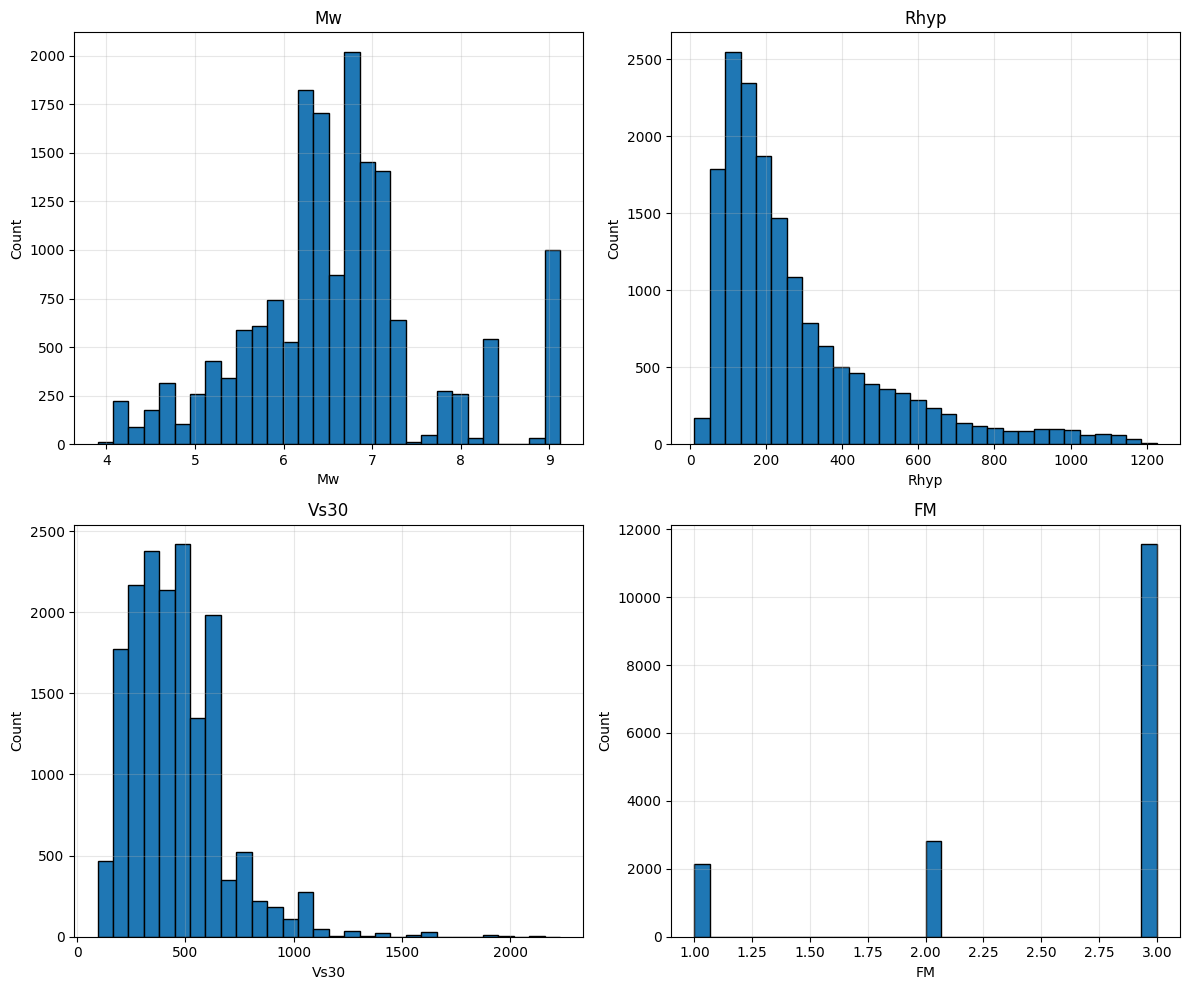

In [43]:
# Data plots
!pip install matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))

# --- Mw ---
plt.subplot(2, 2, 1)
plt.hist(df['Mw'], bins=30, edgecolor='black')
plt.xlabel('Mw')
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.title("Mw")

# --- Rhyp ---
plt.subplot(2, 2, 2)
plt.hist(df['Rhyp'], bins=30, edgecolor='black')
plt.xlabel('Rhyp')
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.title("Rhyp")

# --- Vs30 ---
plt.subplot(2, 2, 3)
plt.hist(df['Vs30'], bins=30, edgecolor='black')
plt.xlabel('Vs30')
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.title("Vs30")

# --- FM ---
plt.subplot(2, 2, 4)
plt.hist(df['FM'], bins=30, edgecolor='black')
plt.xlabel('FM')
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.title("FM")

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Sa')

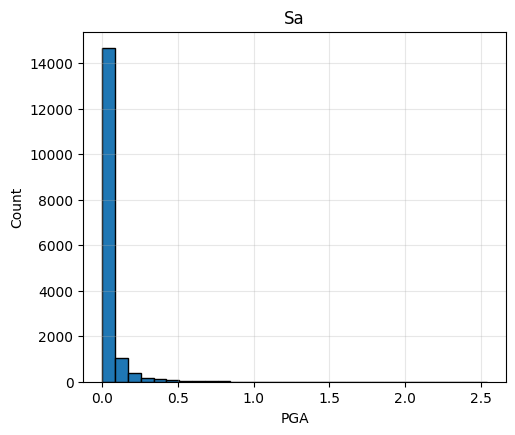

In [44]:
#Data plots
plt.figure(figsize=(12, 10))

# --- Sa ---
plt.subplot(2, 2, 1)
plt.hist(df['SA(T=0)'], bins=30, edgecolor='black')
plt.xlabel('PGA')
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.title("Sa")

In [45]:
# Define inputs and outputs
input_cols = ["Mw", "Rhyp", "Vs30", "FM"]
df["log10_Rhyp"] = np.log10(df["Rhyp"].clip(lower=1e-12))
df["log10_Vs30"] = np.log10(df["Vs30"].clip(lower=1e-12))
X = df[["Mw", "log10_Rhyp", "log10_Vs30", "FM"]]   # input matrix
sa_df = df.drop(columns=input_cols + ["log10_Rhyp", "log10_Vs30"])
Y=np.log10(sa_df)

In [46]:
# Database split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from scipy.stats import pearsonr
# ---- Scaling (mapminmax -> MinMaxScaler range -1 to 1) ----
x_scaler = MinMaxScaler(feature_range=(-1,1))
y_scaler = MinMaxScaler(feature_range=(-1,1))

X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(Y)  # shape (n, n_targets)

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, train_size=0.70, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5)

n_samples = X.shape[0]
print(f"samples: total={n_samples}, train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")

samples: total=16503, train=11552, val=2475, test=2476


In [47]:
# --- MLP Parameters
hidden_size = X_scaled.shape[1]
mlp = MLPRegressor(hidden_layer_sizes=(hidden_size,),
                   activation='tanh',    # hidden activation like tansig
                   solver='adam',        #  adam optimizer
                   max_iter=2000,
                   tol=1e-6,
                   random_state=42,
                   verbose=False)

In [48]:
# ---- Train ----
mlp.fit(X_train, y_train.ravel() if y_train.shape[1]==1 else y_train)

# ---- Predict (on full, train, val, test) and inverse transform to original log10 units ----
y_pred_scaled_full = mlp.predict(X_scaled).reshape(-1, y_scaled.shape[1])
y_pred_full = y_scaler.inverse_transform(y_pred_scaled_full)
y_true_full = Y

y_pred_train = y_scaler.inverse_transform( mlp.predict(X_train).reshape(-1, y_scaled.shape[1]) )
y_true_train = y_scaler.inverse_transform(y_train)

y_pred_val = y_scaler.inverse_transform( mlp.predict(X_val).reshape(-1, y_scaled.shape[1]) )
y_true_val = y_scaler.inverse_transform(y_val)

y_pred_test = y_scaler.inverse_transform( mlp.predict(X_test).reshape(-1, y_scaled.shape[1]) )
y_true_test = y_scaler.inverse_transform(y_test)

In [49]:
import numpy as np
from scipy.stats import pearsonr

def to_2d_numpy(arr):
    """Ensure arr becomes a 2D numpy array of shape (n_samples, n_targets)."""
    if hasattr(arr, "values"):  # pandas Series/DataFrame
        arr_np = arr.values
    else:
        arr_np = np.asarray(arr)
    if arr_np.ndim == 1:
        arr_np = arr_np.reshape(-1, 1)
    return arr_np

def metrics(y_true, y_pred, target_names=None):
    """
    Compute metrics (SD, MSR, PP, R) per target.
    Prints and returns a list of dicts.
    """
    y_true_np = to_2d_numpy(y_true)
    y_pred_np = to_2d_numpy(y_pred)
    n_targets = y_true_np.shape[1]

    # If no target names provided, auto-generate
    if target_names is None:
        target_names = [f"target_{i}" for i in range(n_targets)]

    results = []

    for j in range(4):
        t = y_true_np[:, j]
        p = y_pred_np[:, j]
        err = p - t

        SD  = np.std(err, ddof=0)
        MSR = np.mean(err**2)
        var_t = np.var(t, ddof=0)
        PP  = 1 - MSR / var_t if var_t != 0 else np.nan
        R   = pearsonr(p, t)[0] if len(t) > 1 else np.nan

        results.append({'SD': SD, 'MSR': MSR, 'PP': PP, 'R': R})

        # ---- PRINT HERE ----
        print(f"\n=== Metrics for {target_names[j]} ===")
        print(f" SD  : {SD:.4e}")
        print(f" MSR : {MSR:.4e}")
        print(f" PP  : {PP:.4f}")
        print(f" R   : {R:.4f}")

    return results

In [51]:
print("\n======================")
print("=== TRAIN SET METRICS ===")
print("======================")
train_stats = metrics(y_true_train, y_pred_train)

print("\n===========================")
print("=== VALIDATION SET METRICS ===")
print("===========================")
val_stats   = metrics(y_true_val,   y_pred_val)

print("\n====================")
print("=== TEST SET METRICS ===")
print("====================")
test_stats  = metrics(y_true_test,  y_pred_test)

print("\n====================")
print("=== FULL DATA METRICS ===")
print("====================")
full_stats  = metrics(y_true_full,  y_pred_full)



=== TRAIN SET METRICS ===

=== Metrics for target_0 ===
 SD  : 4.6059e-01
 MSR : 2.1229e-01
 PP  : 0.7537
 R   : 0.8682

=== Metrics for target_1 ===
 SD  : 4.6138e-01
 MSR : 2.1301e-01
 PP  : 0.7532
 R   : 0.8679

=== Metrics for target_2 ===
 SD  : 4.6219e-01
 MSR : 2.1376e-01
 PP  : 0.7527
 R   : 0.8677

=== Metrics for target_3 ===
 SD  : 4.6315e-01
 MSR : 2.1465e-01
 PP  : 0.7521
 R   : 0.8674

=== VALIDATION SET METRICS ===

=== Metrics for target_0 ===
 SD  : 4.5326e-01
 MSR : 2.0559e-01
 PP  : 0.7681
 R   : 0.8766

=== Metrics for target_1 ===
 SD  : 4.5386e-01
 MSR : 2.0613e-01
 PP  : 0.7677
 R   : 0.8764

=== Metrics for target_2 ===
 SD  : 4.5496e-01
 MSR : 2.0714e-01
 PP  : 0.7671
 R   : 0.8761

=== Metrics for target_3 ===
 SD  : 4.5622e-01
 MSR : 2.0830e-01
 PP  : 0.7663
 R   : 0.8756

=== TEST SET METRICS ===

=== Metrics for target_0 ===
 SD  : 4.5559e-01
 MSR : 2.0762e-01
 PP  : 0.7650
 R   : 0.8747

=== Metrics for target_1 ===
 SD  : 4.5601e-01
 MSR : 2.0800e-01
 PP

In [52]:
avg_MSR = np.mean([d['MSR'] for d in train_stats])
print("Average MSR:", avg_MSR)
avg_R = np.mean([d['R'] for d in train_stats])
print("Average R:", avg_R)
avg_SD = np.mean([d['SD'] for d in train_stats])
print("Average SD:", avg_SD)
avg_PP = np.mean([d['PP'] for d in train_stats])
print("Average PP:", avg_PP)

Average MSR: 0.21342531550204763
Average R: 0.8678050780356417
Average SD: 0.4618269537641507
Average PP: 0.7529231755454442


In [ ]:
# ===== Hyperparameter search for hidden layers & neurons =====
from sklearn.model_selection import GridSearchCV
import joblib
import time

# --- Ensure X_train, X_val, X_test, y_train, y_val, y_test, X_scaled, y_scaled exist ---
# (The earlier script already creates these via train_test_split + MinMaxScaler.)

# Build candidate hidden layer configurations:
n_inputs = X_scaled.shape[1]
# Example neuron options (you can expand/shrink)
neuron_options = [max(1, n_inputs//2), n_inputs, n_inputs*2]
# Build layer configurations: 1-layer, 2-layer, 3-layer combos
hidden_layer_list = []
for n in neuron_options:
    hidden_layer_list.append((n,))                 # 1 layer
for n1 in neuron_options:
    for n2 in neuron_options:
        hidden_layer_list.append((n1, n2))        # 2 layers
for n1 in neuron_options[:2]:  # keep 3-layer combos smaller to limit total combos
    for n2 in neuron_options[:2]:
        for n3 in neuron_options[:2]:
            hidden_layer_list.append((n1, n2, n3))

# optional: remove duplicates and sort by total neurons (nice ordering)
hidden_layer_list = list({h for h in hidden_layer_list})
hidden_layer_list.sort(key=lambda h: (len(h), sum(h)))

print(f"Testing {len(hidden_layer_list)} hidden-layer configurations (example list truncated):")
print(hidden_layer_list[:10], " ...")

# --- Base estimator for GridSearch ---
base_mlp = MLPRegressor(activation='tanh', solver='adam', max_iter=2000, tol=1e-6)

param_grid = {'hidden_layer_sizes': hidden_layer_list}

# Use neg_mean_squared_error (GridSearch maximizes score, so neg MSE)
gs = GridSearchCV(base_mlp, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=1)

start_time = time.time()
gs.fit(X_train, y_train.ravel() if y_train.shape[1]==1 else y_train)
elapsed = time.time() - start_time

print(f"\nGridSearch done in {elapsed:.1f}s")
print("Best params:", gs.best_params_)
print("Best CV MSE (negative):", gs.best_score_)

# Best estimator
best_model = gs.best_estimator_

# Evaluate best model on val/test/full (inverse transform back to original log10 units)
def predict_and_inverse(model, X_scaled_subset):
    y_pred_s = model.predict(X_scaled_subset)
    # ensure 2D
    y_pred_s = y_pred_s.reshape(-1, y_scaled.shape[1]) if y_pred_s.ndim == 1 and y_scaled.shape[1] > 1 else np.atleast_2d(y_pred_s).reshape(-1, y_scaled.shape[1])
    return y_scaler.inverse_transform(y_pred_s)

y_pred_train = predict_and_inverse(best_model, X_train)
y_true_train = y_scaler.inverse_transform(y_train)

y_pred_val = predict_and_inverse(best_model, X_val)
y_true_val = y_scaler.inverse_transform(y_val)

y_pred_test = predict_and_inverse(best_model, X_test)
y_true_test = y_scaler.inverse_transform(y_test)

y_pred_full = predict_and_inverse(best_model, X_scaled)
y_true_full = y_scaler.inverse_transform(y_scaled)

# Simple metrics helper (reuse or replace with your simple_metrics)
def simple_metrics_np(y_true_np, y_pred_np):
    """
    Both args are numpy arrays shape (n_samples, n_targets)
    returns list of dicts per target
    """
    results = []
    for j in range(y_true_np.shape[1]):
        t = y_true_np[:, j]
        p = y_pred_np[:, j]
        mse = np.mean((p - t)**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(p - t))
        r = pearsonr(p, t)[0] if len(t) > 1 else np.nan
        results.append({'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R': r})
    return results

train_stats = simple_metrics_np(y_true_train, y_pred_train)
val_stats   = simple_metrics_np(y_true_val,   y_pred_val)
test_stats  = simple_metrics_np(y_true_test,  y_pred_test)
full_stats  = simple_metrics_np(y_true_full,  y_pred_full)

# Print summary
target_names = (
    ["Sa" + col for col in Y.columns] 
    if isinstance(Y, pd.DataFrame) 
    else [f"Sa{i+1}" for i in range(y_scaled.shape[1])]
)
print("\n=== Best model performance ===")
print("Best hidden_layer_sizes:", gs.best_params_['hidden_layer_sizes'])
for i, name in enumerate(target_names):
    tr = train_stats[i]
    va = val_stats[i]
    te = test_stats[i]
    tot = full_stats[i]
    print(f"\n== {name} ==")
    print(f" Train: MSE={tr['MSE']:.4e}, RMSE={tr['RMSE']:.4e}, MAE={tr['MAE']:.4e}, R={tr['R']:.4f}")
    print(f" Val  : MSE={va['MSE']:.4e}, RMSE={va['RMSE']:.4e}, MAE={va['MAE']:.4e}, R={va['R']:.4f}")
    print(f" Test : MSE={te['MSE']:.4e}, RMSE={te['RMSE']:.4e}, MAE={te['MAE']:.4e}, R={te['R']:.4f}")
    print(f" Full : MSE={tot['MSE']:.4e}, RMSE={tot['RMSE']:.4e}, MAE={tot['MAE']:.4e}, R={tot['R']:.4f}")

# Save best model + scalers
joblib.dump({'model': best_model, 'x_scaler': x_scaler, 'y_scaler': y_scaler, 'input_cols': X.columns.tolist(), 'target_cols': (Y.columns.tolist() if isinstance(Y, pd.DataFrame) else None)}, "best_ann_model.joblib")
print("\nSaved best model to 'best_ann_model.joblib'")

Testing 20 hidden-layer configurations (example list truncated):
[(2,), (4,), (8,), (2, 2), (4, 2), (2, 4), (4, 4), (2, 8), (8, 2), (4, 8)]  ...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [57]:
# Print best model architecture
best_hls = gs.best_params_["hidden_layer_sizes"]

print("\n==============================")
print(" BEST NETWORK ARCHITECTURE")
print("==============================")

print(f"Hidden layer sizes: {best_hls}")
print(f"Number of hidden layers: {len(best_hls)}")
print(f"Neurons per layer: {list(best_hls)}")
print(f"Total hidden neurons: {sum(best_hls)}")



 BEST NETWORK ARCHITECTURE
Hidden layer sizes: (8, 8)
Number of hidden layers: 2
Neurons per layer: [8, 8]
Total hidden neurons: 16


In [58]:
# Load Saved model
import joblib

saved = joblib.load("best_ann_model.joblib")

model = saved['model']
x_scaler = saved['x_scaler']
y_scaler = saved['y_scaler']
input_cols = saved['input_cols']
target_cols = saved['target_cols']

print("Model loaded successfully!")
print("Inputs :", input_cols)
print("Targets:", target_cols)


Model loaded successfully!
Inputs : ['Mw', 'log10_Rhyp', 'log10_Vs30', 'FM']
Targets: ['SA(T=0)', 'SA(0.01)', 'SA(0.015)', 'SA(0.02)', 'SA(0.03)', 'SA(0.04)', 'SA(0.05)', 'SA(0.06)', 'SA(0.075)', 'Sa(T0.09)', 'Sa(T0.1)', 'Sa(T0.15)', 'Sa(T0.2)', 'Sa(T0.3)', 'Sa(T0.4)', 'Sa(T0.5)', 'Sa(T0.6)', 'Sa(T0.7)', 'Sa(T0.75)', 'Sa(T0.8)', 'Sa(T0.9)', 'Sa(T1)', 'Sa(T1.2)', 'Sa(T1.5)', 'Sa(T2)', 'Sa(T2.5)', 'Sa(T3)', 'Sa(T4)']


Using input order stored in saved model: ['Mw', 'Rhyp', 'Vs30', 'FM']


/home/varun/.local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/varun/.local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/varun/.local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/varun/.local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/varun/.local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/varun/.local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does no

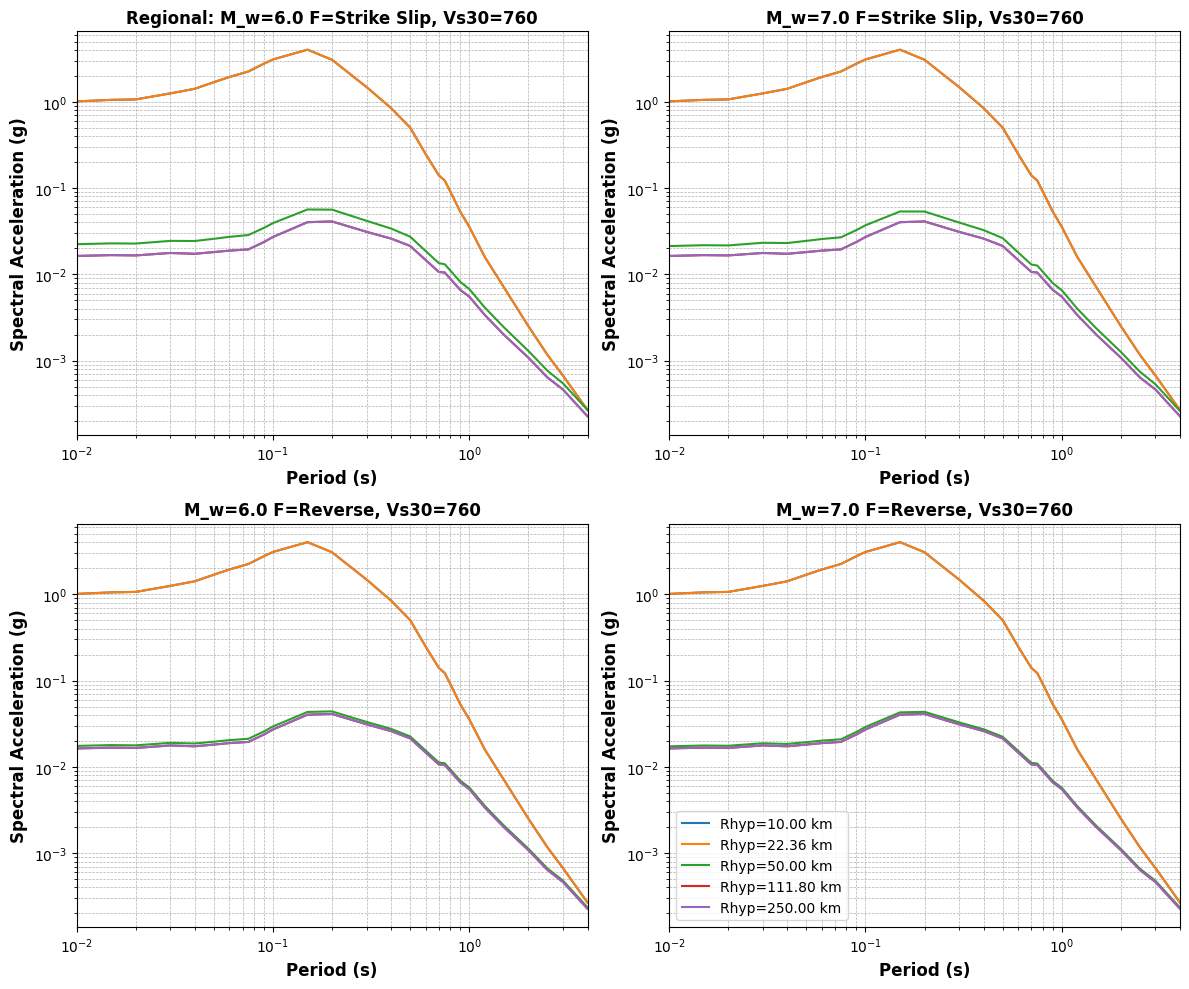

In [55]:
# ----------------- Prepare parameter grid (same as MATLAB) -----------------
T=np.array([0,0.01,0.015,0.02,0.03,0.04,0.05,0.06,0.075,0.09,0.1,0.15,0.2,
            0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1,1.2,1.5,2,2.5,3,4])
M = np.array([6.0, 7.0])
R = np.array([10.0, 22.36, 50.0, 111.80, 250.0])
Vs30 = 760.0
F = np.array([1, 3])   # your two fault types

# ----------------- Determine input order for the model -----------------
# MATLAB used: kk = [M(j) R(i) log10(R(i)) log10(Vs30) D F(k) Flag];
# If saved['input_cols'] exists, try to honor it. Otherwise assume the order below.
if input_cols is not None:
    print("Using input order stored in saved model:", input_cols)
    # We'll build an input dict and then arrange cols per input_cols
    def build_input_row(Mw, Repi, Rhyp, Vs30_val, D_val, Fval, Flag_val):
        # create a dictionary of possible fields
        dd = {
            "Mw": Mw,
            "Rhyp": Rhyp,
            "log10_Rhyp": np.log10(Rhyp),
            "Vs30": Vs30_val,
            "log10_Vs30": np.log10(Vs30_val),
             "FM": Fval,
                  }
        # produce an input row following input_cols order
        return np.array([dd[c] if c in dd else dd.get(c, 0.0) for c in input_cols], dtype=float)
else:
    # fallback default: follow exactly the MATLAB kk ordering (7 inputs)
    print("No input_cols stored; using default ordering: [Mw,log10(R), log10(Vs30), F]")
    def build_input_row(Mw, Rhyp, Vs30_val, Fval):
        return np.array([Mw, np.log10(Rhyp), np.log10(Vs30_val),  Fval], dtype=float)

# ----------------- Helper: model prediction wrapper -----------------
def model_predict_log10Sa(input_array):
    """
    Accepts input_array shape (n_samples, n_features) in the order expected by the model.
    Applies x_scaler (if present), calls model.predict, and returns predicted log10(Sa) array (n_samples, n_periods)
    Note: multi-output support depends on the trained model; here we assume model predicts for all periods T at once,
    OR was trained per-period and returns a 1D output (in which case we call it for each T separately).
    """
    X_in = np.atleast_2d(input_array).astype(float)
    if x_scaler is not None:
        try:
            Xs = x_scaler.transform(X_in)
        except Exception:
            # fallback: pass raw inputs
            Xs = X_in
    else:
        Xs = X_in

    y_pred_s = model.predict(Xs)
    y_pred_s = np.atleast_2d(y_pred_s)

    # If y_scaler exists, inverse-transform
    if y_scaler is not None:
        try:
            y_pred = y_scaler.inverse_transform(y_pred_s)
        except Exception:
            y_pred = y_pred_s
    else:
        y_pred = y_pred_s

    return y_pred  # predicted log10(Sa)

# ----------------- Compute PGA1 array -----------------
# Dimensions: PGA1 over F x M x R x periods (len(F), len(M), len(R), len(T))
PGA1 = np.zeros((len(F), len(M), len(R), T.size), dtype=float)

for k_idx, fk in enumerate(F):
    for j_idx, mj in enumerate(M):
        for i_idx, ri in enumerate(R):
            # build input vector for this parameter combination
            # note: MATLAB used Repi = R(i) ; Rhyp variable naming slightly different — using Rhyp=ri
            input_row = build_input_row(mj, ri, ri, Vs30, D, fk, Flag)  # Repi=ri, Rhyp=ri
            # model may predict a vector for all periods or a scalar per call.
            pred_log10 = model_predict_log10Sa(input_row)  # shape (1, n_out)
            # If the model returns 1 value per call, treat it as single-output and repeat across T
            if pred_log10.size == 1:
                PGA1[k_idx, j_idx, i_idx, :] = 10.0 ** (pred_log10.ravel()[0])
            else:
                # If model returns multiple outputs, ensure length matches T
                out_len = pred_log10.shape[1]
                if out_len == T.size:
                    PGA1[k_idx, j_idx, i_idx, :] = 10.0 ** pred_log10.ravel()
                else:
                    # If lengths differ, try to broadcast or raise
                    if out_len < T.size and out_len == 1:
                        PGA1[k_idx, j_idx, i_idx, :] = 10.0 ** pred_log10.ravel()[0]
                    else:
                        raise ValueError(f"Model returned {out_len} outputs, but T has {T.size} periods. Adjust model or T.")

# ----------------- Prepare plotting (MATLAB-like colormap and style) -----------------
co = plt.get_cmap("hsv")(np.linspace(0, 1, len(R)))

# For x-limits: avoid zero on log scale; choose left limit smallest positive T or 0.01
x_left = np.min(T[T > 0])
x_right = 4.0

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Helper to plot a matrix of curves: R varies over lines
def plot_subplot(ax, pga_matrix, subtitle):
    # pga_matrix has shape (n_R, n_periods)
    for idx in range(pga_matrix.shape[0]):
        ax.loglog(T, pga_matrix[idx, :], linewidth=1.5)
    ax.set_xlabel("Period (s)", fontweight="bold", fontsize=12)
    ax.set_ylabel("Spectral Acceleration (g)", fontweight="bold", fontsize=12)
    ax.set_title(subtitle, fontweight="bold", fontsize=12)
    ax.set_xlim([x_left, x_right])
    ax.grid(True, which="both", ls="--", lw=0.5)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.tick_params(labelsize=10)

# Subplot 1: F=1 (index 0), M index 0 (Mw=6.0)
PGA11 = PGA1[0, 0, :, :]  # shape (n_R, n_T)
plot_subplot(axes[0], PGA11, "Regional: M_w=6.0 F=Strike Slip, Vs30=760")

# Subplot 2: F=1, M index 1 (Mw=7.0)
PGA12 = PGA1[0, 1, :, :]
plot_subplot(axes[1], PGA12, "M_w=7.0 F=Strike Slip, Vs30=760")

# Subplot 3: F=2 (index 1), M index 0
PGA21 = PGA1[1, 0, :, :]
plot_subplot(axes[2], PGA21, "M_w=6.0 F=Reverse, Vs30=760")

# Subplot 4: F=2, M index 1
PGA22 = PGA1[1, 1, :, :]
plot_subplot(axes[3], PGA22, "M_w=7.0 F=Reverse, Vs30=760")

# Legend: label the R-hyp values (use same format as MATLAB)
legend_labels = [f"Rhyp={r:.2f} km" for r in R]
axes[3].legend(legend_labels, loc="best")  # put legend on the last subplot

plt.tight_layout()
plt.show()

# cleanup
plt.close(fig)
